# Echoes of Phonetics: Unveiling Relevant Acoustic Cues for ASR via Feature Attribution

This notebook contains the code used to obtain the results in the Interspeech paper [Echoes of Phonetics: Unveiling Relevant Acoustic Cues for ASR via Feature Attribution](https://)

### Import functions

In [3]:
from typing import Tuple, Dict, Union, List
import json
import h5py

import string
from string import punctuation

from tqdm import tqdm
import itertools

import numpy as np
import math
import pandas as pd
import bisect

import torch
from torch import Tensor

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import seaborn as sns

from jiwer import wer
import parselmouth as pm

### Global variables

In [4]:
ALL_VOWELS = ["iy", "ih", "eh", "ey", "ae", "aa", "aw", "ay", "ah", "ao", "oy", "ow", "uh", "uw", "ux", "er", "ax", "ix", "axr", "ax-h"]

VOWELS = ["aa", "ae", "ah", "eh", "ax", "uh", "ih", "ix", "iy", "ux", "uw"]
VOWEL_MAPPING = {
    "aa": "ɑ",
    "ae": "æ",
    "ah": "ʌ",
    "eh": "ɛ",
    "ax": "ə",
    "uh": "ʊ",
    "ih": "ɪ",
    "ix": "ɨ",
    "iy": "i",
    "ux": "ʉ",
    "uw": "u"}

FRICATIVES = ["s", "z", "sh", "zh", "f", "v", "th", "dh"]
FRICATIVE_MAPPING = {
    "s": "s",
    "z": "z",
    "sh": "ʃ",
    "zh": "ʒ",
    "f": "f",
    "v": "v",
    "th": "θ",
    "dh": "ð"}

SIBILANTS = ["s", "z", "sh", "zh"]
SIBILANTS_IPA = {"s": "s", "z": "z", "sh": "ʃ", "zh": "ʒ"}

NONSIBILANTS = ["f", "v", "th", "dh"]
NONSIBILANTS_IPA = {"f": "f", "v": "v", "th": "θ", "dh": "ð"}

PLOSIVES_CLOS = ["pcl", "bcl", "kcl", "gcl", "tcl", "dcl"]
PLOSIVES_REL = ["p", "b", "k", "g", "t", "d",]

CLOS_2_REL = {"pcl": "p", "bcl": "b", "kcl": "k", "gcl": "g", "tcl": "t", "dcl": "d"}
REL_2_CLOS = {"p": "pcl", "b": "bcl", "k": "kcl", "g": "gcl", "t": "tcl", "d": "dcl"}

SPECTROGRAM_PATH = ""  # path to the folder containing the preprocessed filterbanks

SPACE_TAG = "\u2581"  # special token used by SentencePiece for space

### Frequency and Time conversion functions


In [5]:
def bin_to_frequency(bin_index, frequency_ranges):
    """
    Compute the center frequency of each bin
    """
    return (frequency_ranges[bin_index][0] + frequency_ranges[bin_index][1]) / 2


def mel_to_hertz(mel):
    """
    Converts a Mel value to Hertz using the inverse Mel scale formula.
    """
    return 700 * (10 ** (mel / 2595) - 1)


def mel_bin_frequencies(num_mel_bins, min_freq_hz, max_freq_hz):
    """
    Compute the frequency range for each Mel bin
    """
    # Convert min and max frequencies to Mel scale
    min_mel = 2595 * np.log10(1 + min_freq_hz / 700)
    max_mel = 2595 * np.log10(1 + max_freq_hz / 700)

    # Generate evenly spaced points in Mel scale
    mel_points = np.linspace(min_mel, max_mel, num_mel_bins + 1)

    # Convert Mel points to Hertz
    freq_points = mel_to_hertz(mel_points)

    # Create frequency ranges for each Mel bin
    freq_ranges = [
        (freq_points[i], freq_points[i + 1]) for i in range(num_mel_bins)]
    return freq_ranges


def get_lowest_frame_index(time, window_size=0.025, stride=0.01):
    n = max(0, int(time // stride) - 1)
    # Check if this frame includes the time
    if n * stride <= time < (n * stride + window_size):
        return max(0, n)  # - 1 due to make the index 0-based
    else:
        # Adjust to the next frame
        return max(0, n + 1)  # - 1 due to make the index 0-based


def get_greatest_frame_index(time, window_size=0.025, stride=0.01):
    n = int(time // stride) + 1
    # Check if this frame includes the time
    if n * stride <= time < (n * stride + window_size):
        return n
    else:
        # Adjust to the next frame
        return n + 1

def get_frame_index(time, window_size=0.025, stride=0.01):
    lowest_index = max(0, math.ceil((time - window_size) / stride))
    greatest_index = math.floor(time / stride)
    return math.floor((lowest_index + greatest_index) / 2)

### Aggregation functions

In [6]:
def get_words(tokens: List[str]) -> Tuple[List[str], List[Tuple[int, int]]]:
    words = []
    word_indices = []
    current_word = ""
    start_index = 0
    for i, token in enumerate(tokens):
        if token.strip(SPACE_TAG) in punctuation:  # token is punctuation
            if current_word:
                words.append(current_word)
                word_indices.append((start_index, i - 1))
                current_word = ""
            words.append(token.strip(SPACE_TAG))
            word_indices.append((i, i))

        elif token.startswith(SPACE_TAG):  # token is at beginning position
            if current_word:
                words.append(current_word)
                word_indices.append((start_index, i - 1))
            current_word = token[1:]  # remove the marker
            start_index = i

        elif current_word:  # token is in the middle/end of a word
            current_word += token

        else:  # token is after a punctuation mark or before the first word
            words.append(token)
            word_indices.append((i, i))

    # add the last word
    if current_word:
        words.append(current_word)
        word_indices.append((start_index, len(tokens) - 1))

    return words, word_indices


def aggregate_fbank_explanations(
        aggregation_indices: List[Tuple[int, int]],
        fbank_heatmap: Tensor,
        include_eos: bool = False) -> Tensor:
    # if first indices span is related to </s>, start from the subsequent
    aggregation_indices = aggregation_indices[1:] if include_eos else aggregation_indices

    stack = []
    for start, end in aggregation_indices:
        assert end >= start, "Invalid indices, 'start' is greater than 'end'."
        # Taking the maximum instead of mean
        stack.append(fbank_heatmap[start - 1:end].max(dim=0)[0])

    # if first indices span is related to </s>, add its explanation
    if include_eos:
        stack.append(fbank_heatmap[-1].squeeze(0))

    return torch.stack(stack)


def aggregate_tgt_explanations_rows(
        aggregation_indices: List[Tuple[int, int]],
        tgt_embed_heatmap: Tensor,
        include_eos: bool = False) -> Tensor:
    # if first indices span is related to </s>, start from the subsequent
    # span for dimension 0, but not for dimension 1
    aggregation_indices = aggregation_indices[1:] if include_eos else aggregation_indices
    stack = []
    # iterate over rows (dimension 0)
    for row_ind_start, row_ind_end in aggregation_indices:
        assert row_ind_end >= row_ind_start, "Invalid indices, 'start' is greater than 'end'."
        # Taking the maximum instead of mean
        max_tgt = tgt_embed_heatmap[row_ind_start - 1:row_ind_end].max(dim=0)[0]
        # pad from the current word onwards to exclude
        # the first token of the word from the explanation.
        max_tgt[row_ind_start:] = 0
        stack.append(max_tgt)

    # add last explanations for </s>
    if include_eos:
        stack.append(tgt_embed_heatmap[-1])

    return torch.stack(stack)


def do_aggregation(
        explanations: Dict[int, Dict[str, Union[Tensor, str, List[str]]]],
        indices: Dict[int, Tuple[List[str], List[Tuple[int, int]]]] = None
) -> Dict[int, Dict[str, Union[Tensor, List[str]]]]:
    for sample_id in list(explanations.keys()):
        if indices:
            try:
                phrases, aggregation_indices = indices[sample_id]
            except KeyError:
                raise KeyError(f"Sample_id {sample_id} not available in provided indices.")
        else:
            tgt_text = explanations[sample_id]["tgt_text"]
            phrases, aggregation_indices = get_words(tgt_text)

        assert len(phrases) == len(aggregation_indices), \
            f"Size of indices ({len(aggregation_indices)}) does not correspond to the size " \
            f"of phrases ({len(phrases)})."

        if aggregation_indices:  # empty tuple means that no aggregation is performed
            fbank_heatmap = explanations[sample_id]["fbank_heatmap"]
            tgt_embed_heatmap = explanations[sample_id]["tgt_embed_heatmap"]

            include_eos = True if (0, 0) in aggregation_indices else False
            aggregated_fbank_explanations = aggregate_fbank_explanations(
                aggregation_indices, fbank_heatmap, include_eos)
            aggregated_tgt_explanations = aggregate_tgt_explanations_rows(
                aggregation_indices, tgt_embed_heatmap, include_eos)

            explanations[sample_id]["fbank_heatmap"] = aggregated_fbank_explanations
            explanations[sample_id]["tgt_embed_heatmap"] = aggregated_tgt_explanations
            explanations[sample_id]["tgt_phrases"] = phrases
        else:
            del explanations[sample_id]

    return explanations

### Normalization functions

In [7]:
def mean_std_normalization(fbank_map: Tensor) -> Tensor:
    """
    Perform mean-standard deviation normalization of fbanks
    map related to a single token along the first dimension.
    """
    tokens_size = fbank_map.shape[0]
    flattened_fbank = fbank_map.view(tokens_size, -1)
    row_wise_count = flattened_fbank.shape[1]
    expected_values = flattened_fbank.sum(dim=1) / row_wise_count
    expected_squared_values = (flattened_fbank ** 2).sum(dim=1) / row_wise_count
    momentum_order_2 = expected_squared_values - expected_values ** 2
    # std_devs = torch.sqrt(momentum_order_2 * (row_wise_count - 1) / row_wise_count)
    std_devs = torch.sqrt(momentum_order_2)
    expected_values = expected_values.unsqueeze(-1).unsqueeze(-1)
    std_devs = std_devs.unsqueeze(-1).unsqueeze(-1)
    fbank_map_norm = (fbank_map - expected_values) / std_devs
    return fbank_map_norm


def min_max_normalization(fbank_map: Tensor) -> Tensor:
    """
    Perform min-max normalization across a single 2D fbank explanation.
    """
    min_val = fbank_map.min()
    max_val = fbank_map.max()
    range_val = max_val - min_val
    normalized_fbank = (fbank_map - min_val) / range_val
    return normalized_fbank

### Utils

In [ ]:
def read_feature_attribution_maps_from_h5(explanation_path: str) -> Dict[int, Dict[str, Tensor]]:
    explanations = {}
    with h5py.File(explanation_path, "r") as f:
        for key in f.keys():
            explanations[int(key)] = {}
            group = f[key]
            explanations[int(key)]["fbank_heatmap"] = torch.from_numpy(
                group["fbank_heatmap"][()])
            explanations[int(key)]["tgt_embed_heatmap"] = torch.from_numpy(
                group["tgt_embed_heatmap"][()])
            tgt_txt = group["tgt_text"][()]
            explanations[int(key)]["tgt_text"] = [x.decode('UTF-8') for x in tgt_txt.tolist()]
    return explanations


def cap_exp(explanation: torch.Tensor, percentile: int = 97):
  value_at_percentile = torch.quantile(explanation.flatten(), percentile / 100)
  explanation[explanation < value_at_percentile] = 0
  explanation[explanation >= value_at_percentile] = 1
  return explanation


def get_wer(row):
    hypo = row["output"].translate(str.maketrans('', '', string.punctuation))
    ref = row["tgt_text"].translate(str.maketrans('', '', string.punctuation))
    return wer(ref.lower(), hypo.lower())

### Analysis functions

In [8]:
def get_phon_duration(p_start: int, p_end: int, sample_rate: int):
    phon_span_length_ms = (p_end - p_start) / sample_rate * 1000
    return phon_span_length_ms


def get_ratio(fbank: Tensor, word_index: int, start_frame: int, end_frame: int):
    # Check if the time span is valid, meaning that at least one frame is considered
    if end_frame - start_frame == 0:
        end_frame = start_frame + 1

    span = fbank[word_index, start_frame:end_frame]  # the starting frame
    # goes with previous span, the final goes with the current span

    span_length_frames = span.shape[0]

    n_active_phon = (span != 0.).sum()
    ratio = (n_active_phon * 100 / span_length_frames).item()

    return ratio


def get_peak_match(spectrogram: Tensor, fbank: Tensor, strict: bool = True) -> int:
    # Find the location(s) of the spectral peak
    max_indices = torch.nonzero(spectrogram == torch.max(spectrogram), as_tuple=True)

    # Get the scores associated with the peak location(s)
    found_scores = fbank[max_indices]

    # Strict mode: all matches must be non-zero (salient)
    # Non-strict mode: at least one match must be non-zero (salient)
    return int(torch.all(found_scores > 0) if strict else torch.any(found_scores > 0))


def get_formants(waveform_path: str, gender: str, ms_instant: int):
    sound = pm.Sound(waveform_path)
    max_duration = sound.get_total_duration() * 1000  # convert to ms
    assert ms_instant < max_duration, "the instant is out of the maximum duration"

    max_formant = 5500 if gender == "F" else 5000
    formant_obj = sound.to_formant_burg(
        time_step=0.01, max_number_of_formants=5.0, maximum_formant=max_formant)

    formant_values = {}
    for f in range(1, 5):
        formant_values[f"f{f}"] = formant_obj.get_value_at_time(
            formant_number=f, time=ms_instant/1000)

    return formant_values


def find_bin_index(bin_centers: List, value: float) -> int:
    pos = bisect.bisect_left(bin_centers, value)  # find the closest bin

    # Handle edge cases
    if pos == 0:
        return 0
    if pos == len(bin_centers):
        return len(bin_centers) - 1

    # Check which bin center is closer
    before = bin_centers[pos - 1]
    after = bin_centers[pos]
    return pos if abs(after - value) < abs(before - value) else pos - 1


def get_formant_match(
    waveform_path: str,
    gender: str,
    ms_instant: int,
    exp_slice: Tensor,
    hz_centers: List[int]) -> Tuple[Tensor, Tensor]:
    formant_values = get_formants(waveform_path, gender, ms_instant)

    matched = []
    formants = []
    for i in range(1, 5):
        formant_mel_index = find_bin_index(hz_centers, formant_values[f"f{i}"])
        matched.append(exp_slice[formant_mel_index])
        formants.append(formant_values[f"f{i}"])

    return formant_values, torch.tensor(matched)

In [9]:
def main(
    fbank: torch.Tensor,
    spectrogram: torch.Tensor,
    waveform_path: str,
    phrase_text: List[str],
    ortographic_data: dict,
    phonetic_data: dict,
    gender: str,
    count_dict: dict,
    sample_rate: int = 16000,
    min_freq_hz: int = 20,
    max_freq_hz: int = 8000):

    frequency_ranges = mel_bin_frequencies(80, min_freq_hz, max_freq_hz)
    hz_centers = [bin_to_frequency(i, frequency_ranges) for i in range(80)]

    fbank_2d = fbank.clone()
    fbank = fbank.max(dim=2)[0]

    starting_index = 0
    for i, word_predicted in enumerate(phrase_text):
        word_predicted = word_predicted.lower()

        if word_predicted != "</s>" and word_predicted not in punctuation:

            # Match the predicted word with the reference words
            for k, (w_start, w_end, word_reference) in enumerate(ortographic_data[starting_index:]):
                word_reference = word_reference.replace("'", "").lower()

                if word_predicted == word_reference:

                    # Find phonemes within the matched word
                    for l, (p_start, p_end, phoneme) in enumerate(phonetic_data):
                        if w_start <= p_start < w_end:

                            # Analyze context for plosives
                            next_phoneme = phonetic_data[l+1][2] if l+1 < len(phonetic_data) else None
                            next_next_phoneme = phonetic_data[l+2][2] if l+2 < len(phonetic_data) else None
                            prev_phoneme = phonetic_data[l-1][2] if l-1 >= 0 else None

                            # Analyze only the phonemes we are interested in
                            if (phoneme in FRICATIVES or
                                phoneme in VOWELS or
                                (phoneme in PLOSIVES_CLOS and next_phoneme == CLOS_2_REL[phoneme] and next_next_phoneme in ALL_VOWELS) or
                                (phoneme in PLOSIVES_REL and prev_phoneme == REL_2_CLOS[phoneme] and next_phoneme in ALL_VOWELS)):

                                start_frame = get_frame_index(p_start / sample_rate)
                                end_frame = get_frame_index(p_end / sample_rate)

                                # Get duration statistics
                                phon_span_length_ms = get_phon_duration(p_start, p_end, sample_rate)
                                phon_ratio = get_ratio(fbank, i, start_frame, end_frame)

                                matched = 0
                                exp_slice = 0
                                spec_slice = 0
                                cue = 0

                                # Get frequency matching
                                if phoneme in FRICATIVES:  # spectral peak location at middle point for fricatives
                                    middle_frame = (p_end + p_start) // 2
                                    middle_frame = get_frame_index(middle_frame / sample_rate)
                                    exp_slice = fbank_2d[i, middle_frame]
                                    spec_slice = spectrogram[middle_frame]
                                    matched = get_peak_match(spec_slice, exp_slice, strict=False)

                                if phoneme in PLOSIVES_REL:  # spectral peak location at release onset
                                    exp_slice = fbank_2d[i, start_frame:start_frame + 2]  # get first 35ms (2 frames) after the release onset
                                    spec_slice = spectrogram[start_frame:start_frame + 2]
                                    matched = get_peak_match(spec_slice, exp_slice, strict=False)
                                    # Aggregate the two frames with max for saliency map and mean in spectrogram
                                    exp_slice = exp_slice.max(dim=0).values
                                    spec_slice = spec_slice.mean(dim=0)

                                if phoneme in VOWELS:  # first four formants at middle point for vowels
                                    middle_sample = (p_end + p_start) // 2
                                    middle_frame = get_frame_index(middle_sample / sample_rate)
                                    exp_slice = fbank_2d[i, middle_frame]
                                    spec_slice = 0  # not useful for vowels
                                    cue, matched = get_formant_match(
                                        waveform_path,
                                        gender,
                                        middle_sample / sample_rate * 1000,
                                        exp_slice,
                                        hz_centers)  # formants and matched are Tensor

                                # Update results
                                if phoneme in count_dict:
                                    count_dict[phoneme]["count"] += 1  # number of occurrences for each phoneme
                                    count_dict[phoneme]["ratio"].append(phon_ratio)
                                    count_dict[phoneme]["length"].append(phon_span_length_ms)
                                    count_dict[phoneme]["matched"].append(matched)
                                    count_dict[phoneme]["exp_frame"].append(exp_slice)
                                    count_dict[phoneme]["spec_frame"].append(spec_slice)
                                    count_dict[phoneme]["cue"].append(cue)
                                else:
                                    count_dict[phoneme] = {
                                        "count": 1,
                                        "ratio": [phon_ratio],
                                        "length": [phon_span_length_ms],
                                        "matched": [matched],
                                        "exp_frame": [exp_slice],
                                        "spec_frame": [spec_slice],
                                        "cue": [cue]}

                    # Word Duration analysis
                    start_frame = get_frame_index(w_start / sample_rate)
                    end_frame = get_frame_index(w_end / sample_rate)
                    word_ratio = get_ratio(fbank, i, start_frame, end_frame)

                    # Update results
                    if "word" in count_dict:
                        count_dict["word"].append(word_ratio)
                    else:
                        count_dict["word"] = [word_ratio]

                    # Update alignment
                    starting_index += k + 1
                    break

    return count_dict

### Process explanations and obtain results

In [10]:
# Load tsv data
tsv_path = ""   # `${DATA_FILENAME}.tsv`
data = pd.read_csv(tsv_path, sep='\t')

# Load phonetic annotations
json_path = ""  # `${JSON_PHONETIC}`
with open(json_path, "r") as f:
    phonetic_data = json.load(f)

# Load orthographic annotations
json_path = ""  # `${JSON_ORTHOGRAPHIC}`
with open(json_path, "r") as f:
    ortographic_data = json.load(f)

# Load explanations
path = ""  # `${SALIENCY_MAPS}`
explanations = read_feature_attribution_maps_from_h5(path)


min_freq_hz = 20
max_freq_hz = 8000
frequency_ranges = mel_bin_frequencies(80, min_freq_hz, max_freq_hz)
f = [bin_to_frequency(i, frequency_ranges) for i in range(80)]

count_dict_M = {}
count_dict_F = {}

skipped_rows = 0
for key, explanation in tqdm(explanations.items(), desc="Processing explanations"):

    gender = data.iloc[int(key)]["speaker"][0]

    spectrogram_path = SPECTROGRAM_PATH + data.iloc[int(key)]["id"] + ".npy"
    spectrogram = torch.from_numpy(np.load(spectrogram_path))

    wav_folder = ""  # WAV files should be stored in a folder on Google Drive
    waveform_path = wav_folder + data.iloc[int(key)]["wav"]

    # WER filtering
    wer_score = get_wer(data.iloc[int(key)])

    if wer_score == 0:

        # Normalization and aggregation
        explanation["fbank_heatmap"] = mean_std_normalization(explanation["fbank_heatmap"])
        _explanations = {key: explanation}
        _explanations = do_aggregation(_explanations)
        fbank = _explanations[key]["fbank_heatmap"]
        fbank = min_max_normalization(fbank)
        text = _explanations[key]["tgt_phrases"]
        text.append(text.pop(0))

        has_nan = torch.isnan(fbank)
        any_nan = has_nan.any()
        if any_nan:
            print(f"Skipping key {key} because of nan values")

        else:
            fbank = cap_exp(fbank)

            if gender == "M":
                count_dict_M = main(
                    fbank, spectrogram, waveform_path,
                    text, ortographic_data[str(key)], phonetic_data[str(key)],
                    gender,
                    count_dict_M)
            else:
                count_dict_F = main(
                    fbank, spectrogram, waveform_path,
                    text, ortographic_data[str(key)], phonetic_data[str(key)],
                    gender,
                    count_dict_F)

    else:
        skipped_rows += 1

print(f"{skipped_rows} skipped rows")

Processing explanations: 100%|██████████| 3150/3150 [2:38:30<00:00,  3.02s/it]

958 skipped rows


In [11]:
# Aggregate M and F results
count_dict_all = {}
for k in count_dict_F:
    if type(count_dict_F[k]) == list:
        count_dict_all[k] = count_dict_F[k] + count_dict_M[k]
    else:
        count_dict_all[k] = {}
        for l in count_dict_F[k]:
            count_dict_all[k][l] = count_dict_F[k][l] + count_dict_M[k][l]

assert count_dict_all.keys() == count_dict_F.keys() == count_dict_M.keys()

In [13]:
# WER
data['refs'] = data['tgt_text'].apply(
    lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))
data['hyps'] = data["output"].apply(
    lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))

data_test = data[data["split"] == "TEST"]
data_test['refs'] = data_test['tgt_text'].apply(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))
data_test['hyps'] = data_test["output"].apply(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))

print(f"WER SX subset (train + test): {wer(data['refs'].to_list(), data['hyps'].to_list())}")
print(f"WER SX subset (test): {wer(data_test['refs'].to_list(), data_test['hyps'].to_list())}")

<ipython-input-13-820c2fd4b7f2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['refs'] = data_test['tgt_text'].apply(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))
<ipython-input-13-820c2fd4b7f2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['hyps'] = data_test["output"].apply(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))


WER SX subset (train + test): 0.06685740732949047
WER SX subset (test): 0.061014263074484945


### Count occurrences of phones




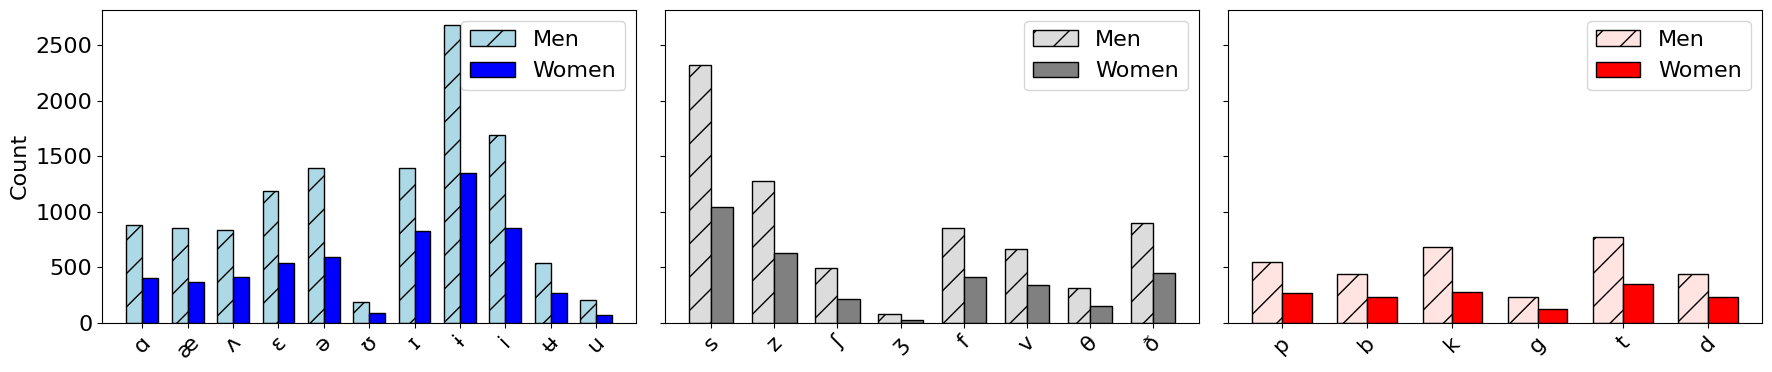

PHONEME aa
Masculine --- 879
Feminine --- 399
All --- 1278
##############################
PHONEME ae
Masculine --- 849
Feminine --- 365
All --- 1214
##############################
PHONEME ah
Masculine --- 834
Feminine --- 413
All --- 1247
##############################
PHONEME eh
Masculine --- 1189
Feminine --- 537
All --- 1726
##############################
PHONEME ax
Masculine --- 1395
Feminine --- 589
All --- 1984
##############################
PHONEME uh
Masculine --- 188
Feminine --- 87
All --- 275
##############################
PHONEME ih
Masculine --- 1398
Feminine --- 826
All --- 2224
##############################
PHONEME ix
Masculine --- 2683
Feminine --- 1349
All --- 4032
##############################
PHONEME iy
Masculine --- 1692
Feminine --- 849
All --- 2541
##############################
PHONEME ux
Masculine --- 541
Feminine --- 269
All --- 810
##############################
PHONEME uw
Masculine --- 201
Feminine --- 68
All --- 269
##############################
PHONEME p

In [29]:
group_styles = {
    "vowels": {"color_light": "lightblue", "color_dark": "blue", "hatch_light": "/", "hatch_dark": ""},
    "fricatives": {"color_light": "gainsboro", "color_dark": "gray", "hatch_light": "/", "hatch_dark": ""},
    "plosives": {"color_light": "mistyrose", "color_dark": "red", "hatch_light": "/", "hatch_dark": ""},}
all_groups = {
    "vowels": VOWELS,
    "fricatives": FRICATIVES,
    "plosives": PLOSIVES_REL,}

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

bar_width = 0.35  # Fixed bar width
for idx, (group_name, phonemes) in enumerate(all_groups.items()):
    x_positions = np.arange(len(phonemes))  # Positions for the bars

    masculine_counts = [count_dict_M[p]["count"] for p in phonemes]
    feminine_counts = [count_dict_F[p]["count"] for p in phonemes]

    # M bars
    axes[idx].bar(
        x_positions - bar_width / 2, masculine_counts, bar_width,
        color=group_styles[group_name]["color_light"],
        edgecolor="black",
        hatch=group_styles[group_name]["hatch_light"],
        label="Men")

    # F bars
    axes[idx].bar(
        x_positions + bar_width / 2, feminine_counts, bar_width,
        color=group_styles[group_name]["color_dark"],
        edgecolor="black",
        hatch=group_styles[group_name]["hatch_dark"],
        label="Women")

    if group_name == "vowels":
        phonemes = [VOWEL_MAPPING[p] for p in phonemes]
    elif group_name == "fricatives":
        phonemes = [FRICATIVE_MAPPING[p] for p in phonemes]

    axes[idx].set_ylabel("Count" if idx == 0 else "", fontsize=16)
    axes[idx].set_xticks(x_positions)
    axes[idx].set_xticklabels(phonemes, fontsize=16, rotation=45)
    axes[idx].tick_params(axis="y", labelsize=16)
    axes[idx].legend(fontsize=16)

plt.tight_layout()
plt.show()

for p in VOWELS + PLOSIVES_REL + FRICATIVES:
    print(f"PHONEME {p}")
    print(f"Masculine --- {count_dict_M[p]['count']}")
    print(f"Feminine --- {count_dict_F[p]['count']}")
    print(f"All --- {count_dict_all[p]['count']}")
    print("##############################")

### **Time Coverage**

In [15]:
print(f"ALL --- mean: {np.mean(count_dict_all['word'])}, std: {np.std(count_dict_all['word'])}")
print(f"F --- mean: {np.mean(count_dict_F['word'])}, std: {np.std(count_dict_F['word'])}")
print(f"M --- mean: {np.mean(count_dict_M['word'])}, std: {np.std(count_dict_M['word'])}")

ALL --- mean: 87.78709775294443, std: 13.523876966360739
F --- mean: 87.69484273958562, std: 13.457418436882987
M --- mean: 87.82982444372084, std: 13.554333207298587


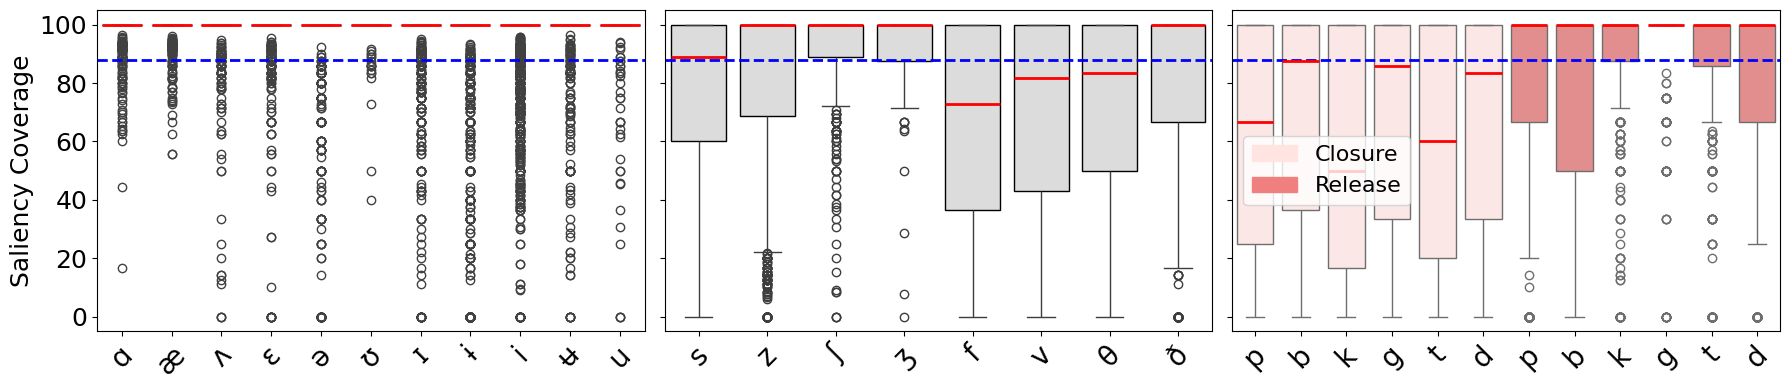

PHONEME aa
Masculine --- 120.06029579067122, 41.18377282545762
Feminine --- 126.74953007518798, 48.79457458030329
All --- 122.14871870109546, 43.8122465099132
##############################
PHONEME ae
Masculine --- 132.7422703180212, 41.349753346330495
Feminine --- 138.1304794520548, 46.098350181933334
All --- 134.36228377265238, 42.9040442205797
##############################
PHONEME ah
Masculine --- 86.58235911270984, 31.723392421228628
Feminine --- 87.23622881355932, 34.92793717277885
All --- 86.79891740176423, 32.820836432221824
##############################
PHONEME eh
Masculine --- 88.12521026072329, 29.55964728371758
Feminine --- 91.3780260707635, 30.122118519946003
All --- 89.1372392815759, 29.773892858368146
##############################
PHONEME ax
Masculine --- 47.88378136200717, 16.930516377395108
Feminine --- 47.93378607809847, 16.69220958199602
All --- 47.898626512096776, 16.860136080981867
##############################
PHONEME uh
Masculine --- 77.30053191489361, 28.5036

In [16]:
group_data = {
    "Vowels": {
        "data": [count_dict_all[p]["ratio"] for p in VOWEL_MAPPING.keys()],
        "labels": [VOWEL_MAPPING[p] for p in VOWEL_MAPPING.keys()],
        "boxprops": {"boxprops": {"facecolor": "lightblue", "edgecolor": "black"}}},
    "Fricatives": {
        "data": [count_dict_all[p]["ratio"] for p in FRICATIVES],
        "labels": [FRICATIVE_MAPPING[p] for p in FRICATIVE_MAPPING.keys()],
        "boxprops": {"boxprops": {"facecolor": "gainsboro", "edgecolor": "black"}}},
    "Plosives": {
        "data": [count_dict_all[p]["ratio"] for p in PLOSIVES_CLOS + PLOSIVES_REL],
        "labels": ["p", "b", "k", "g", "t", "d", "p", "b", "k", "g", "t", "d"],
        "boxprops": {"palette": ["mistyrose"] * len(PLOSIVES_CLOS) + ["lightcoral"] * len(PLOSIVES_REL)},
        "legend": [
            mpatches.Patch(color="mistyrose", label="Closure"),
            mpatches.Patch(color="lightcoral", label="Release")]}}

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

for idx, (group_name, group_info) in enumerate(group_data.items()):
    sns.boxplot(
        ax=axes[idx],
        data=group_info["data"],
        showfliers=True,
        medianprops={"color": "red", "linewidth": 2},
        **group_info["boxprops"])

    axes[idx].set_xticks(range(len(group_info["labels"])))
    axes[idx].set_xticklabels(group_info["labels"], fontsize=20, rotation=45)
    axes[idx].tick_params(axis="y", labelsize=18)

    # Add horizontal line
    axes[idx].axhline(y=87.79, color="blue", linestyle="--", linewidth=2)

    # Add custom legend for Plosives
    if "legend" in group_info:
        axes[idx].legend(handles=group_info["legend"], fontsize=16)

axes[0].set_ylabel("Saliency Coverage", fontsize=18)

plt.tight_layout()
plt.show()


for p in VOWELS + PLOSIVES_CLOS + PLOSIVES_REL + FRICATIVES:
    print(f"PHONEME {p}")
    print(f"Masculine --- {np.mean(count_dict_M[p]['length'])}, {np.std(count_dict_M[p]['length'])}")
    print(f"Feminine --- {np.mean(count_dict_F[p]['length'])}, {np.std(count_dict_F[p]['length'])}")
    print(f"All --- {np.mean(count_dict_all[p]['length'])}, {np.std(count_dict_all[p]['length'])}")
    print("##############################")

### **Spectral Match**


Vowel Formant Match Rates (%)
Vowel   F1-M   F1-F     F2-M   F2-F     F3-M   F3-F     F4-M   F4-F  
---------------------------------------------------------------------
ɑ       94.5   85.7   91.8   88.7   43.7   44.4   24.1   22.1
æ       96.5   87.9   97.1   90.7   60.4   67.7   27.2   25.8
ʌ       86.7   75.5   90.2   88.9   35.9   36.8   31.3   35.6
ɛ       90.4   79.0   93.3   87.9   67.2   65.7   28.9   30.4
ə       70.2   60.4   76.7   70.3   31.1   33.4   24.5   27.8
ʊ       74.5   73.6   74.5   64.4   35.1   34.5   29.3   27.6
ɪ       64.9   56.4   78.8   74.5   59.4   59.7   35.8   38.7
ɨ       54.4   52.0   69.6   62.3   42.5   41.3   25.5   23.7
i       42.7   36.3   61.1   54.2   51.8   58.3   43.0   37.1
ʉ       55.5   51.7   52.7   56.9   50.6   48.0   29.6   33.5
u       55.2   54.4   55.2   57.4   33.3   29.4   18.4   17.6


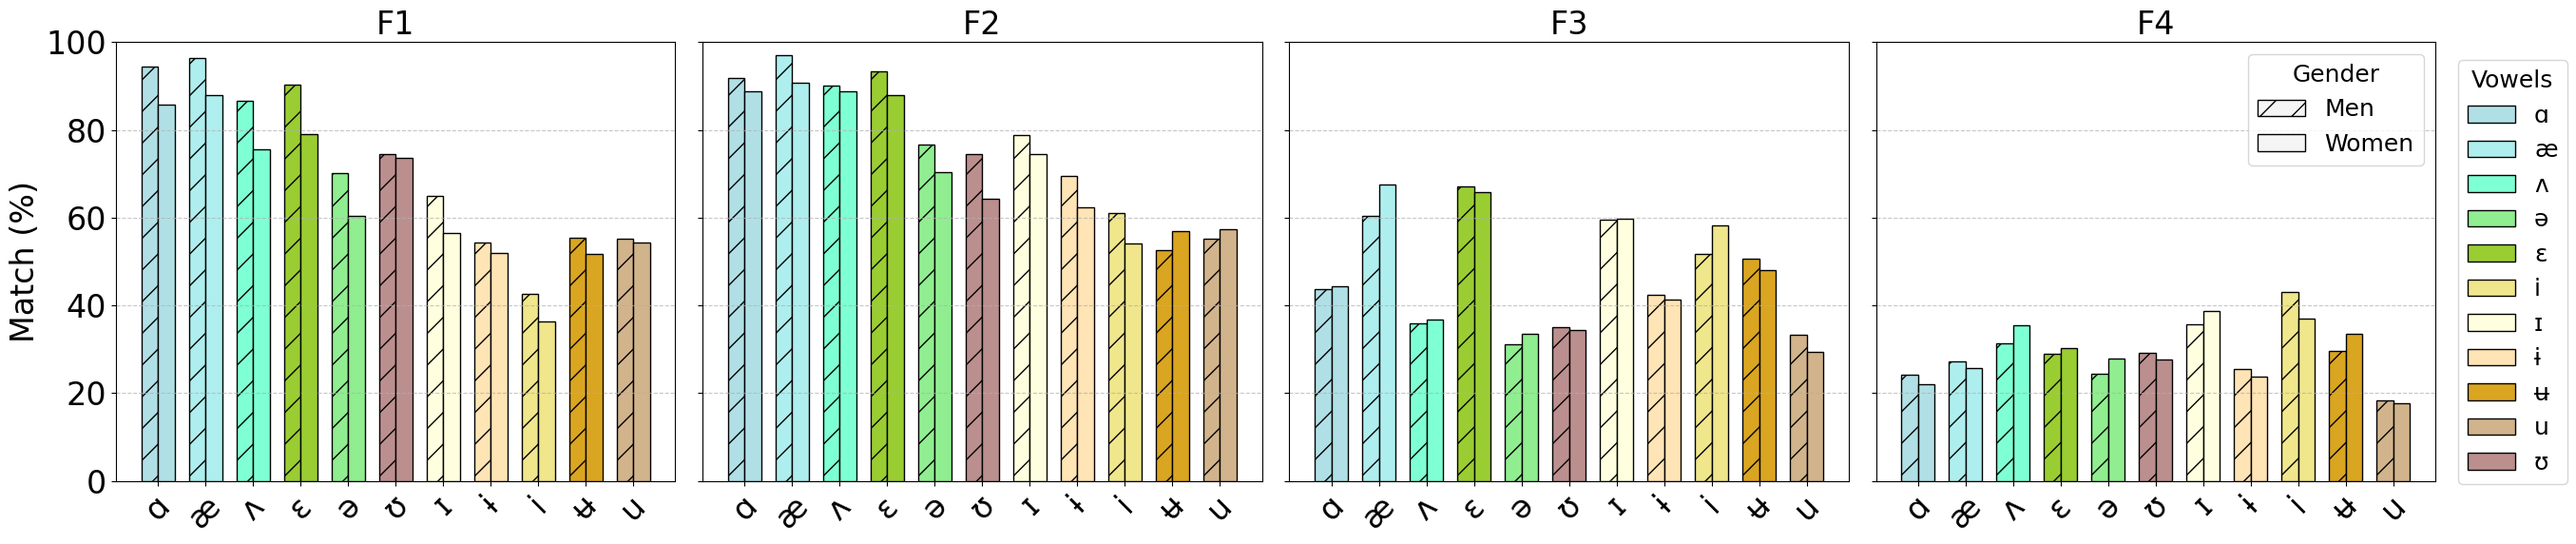

In [34]:
def compute_vowel_scores(count_dict_M, count_dict_F, VOWELS):
    percentage_matched_M = []
    percentage_matched_F = []

    for vowel in VOWELS:
        matched_M = torch.stack(count_dict_M[vowel]["matched"])
        percentage_M = torch.sum(matched_M, dim=0) / matched_M.shape[0] * 100
        percentage_matched_M.append(percentage_M)

        matched_F = torch.stack(count_dict_F[vowel]["matched"])
        percentage_F = torch.sum(matched_F, dim=0) / matched_F.shape[0] * 100
        percentage_matched_F.append(percentage_F)

    percentage_matched_M = torch.stack(percentage_matched_M).numpy()
    percentage_matched_F = torch.stack(percentage_matched_F).numpy()

    return percentage_matched_M, percentage_matched_F


scores_M, scores_F = compute_vowel_scores(count_dict_M, count_dict_F, VOWELS)


def print_vowel_scores(percentage_matched_M, percentage_matched_F, VOWELS, VOWEL_MAPPING):
    formants = ["F1", "F2", "F3", "F4"]

    print("\nVowel Formant Match Rates (%)")
    header = f"{'Vowel':<6} " + "  ".join([f"{f}-M".center(6) + f"{f}-F".center(8) for f in formants])
    print(header)
    print("-" * len(header))

    for i, vowel in enumerate(VOWELS):
        row = f"{VOWEL_MAPPING[vowel]:<6} "
        row += "  ".join(f"{percentage_matched_M[i,j]:5.1f}  {percentage_matched_F[i,j]:5.1f}" for j in range(4))
        print(row)


print_vowel_scores(scores_M, scores_F, VOWELS, VOWEL_MAPPING)


def plot_vowel_formants(percentage_matched_M, percentage_matched_F, VOWELS, VOWEL_MAPPING):
    font_size = 24
    formants = ["F1", "F2", "F3", "F4"]

    vowel_colors = {
        "aa": "powderblue", "ae": "paleturquoise", "ah": "aquamarine", "ax": "lightgreen",
        "eh": "yellowgreen", "iy": "khaki", "ih": "lightyellow", "ix": "moccasin",
        "ux": "goldenrod", "uw": "tan", "uh": "rosybrown"}

    group_styles = {
        "M": {"hatch": "/", "label": "Men"},
        "F": {"hatch": "",  "label": "Women"}}

    fig, axes = plt.subplots(1, 4, figsize=(26, 6), sharey=True)
    bar_width = 0.35
    x_positions = np.arange(len(VOWELS))

    for i, formant in enumerate(formants):
        for j, vowel in enumerate(VOWELS):
            male_val = percentage_matched_M[j, i]
            female_val = percentage_matched_F[j, i]

            axes[i].bar(
                x_positions[j] - bar_width / 2, male_val, bar_width,
                color=vowel_colors[vowel], edgecolor="black", hatch=group_styles["M"]["hatch"])
            axes[i].bar(
                x_positions[j] + bar_width / 2, female_val, bar_width,
                color=vowel_colors[vowel], edgecolor="black", hatch=group_styles["F"]["hatch"])

        axes[i].set_title(formant, fontsize=font_size)
        axes[i].set_xticks(x_positions)
        axes[i].set_xticklabels([VOWEL_MAPPING[v] for v in VOWELS], fontsize=font_size, rotation=45)
        axes[i].tick_params(axis="y", labelsize=font_size)
        axes[i].grid(axis="y", linestyle="--", alpha=0.7)

    axes[0].set_ylabel("Match (%)", fontsize=font_size)
    axes[0].set_yticks(np.arange(0, 101, 20))
    axes[0].set_ylim(0, 100)

    # Legends
    gender_handles = [
        Patch(facecolor="whitesmoke", hatch=group_styles["M"]["hatch"], label=group_styles["M"]["label"], edgecolor="black"),
        Patch(facecolor="whitesmoke", hatch=group_styles["F"]["hatch"], label=group_styles["F"]["label"], edgecolor="black")]

    vowel_handles = [
        Patch(facecolor=color, label=VOWEL_MAPPING[vowel], edgecolor="black") for vowel, color in vowel_colors.items()]

    axes[3].legend(handles=gender_handles, fontsize=18, loc="upper right", title="Gender", title_fontsize=18)
    fig.legend(handles=vowel_handles, fontsize=18, title="Vowels", title_fontsize=18,
               loc="center left", bbox_to_anchor=(1.0, 0.5), borderaxespad=0)

    plt.subplots_adjust(right=0.85)
    plt.tight_layout()
    plt.show()


plot_vowel_formants(scores_M, scores_F, VOWELS, VOWEL_MAPPING)

### **Distribution** of salient elements across frequencies

#### Fricatives

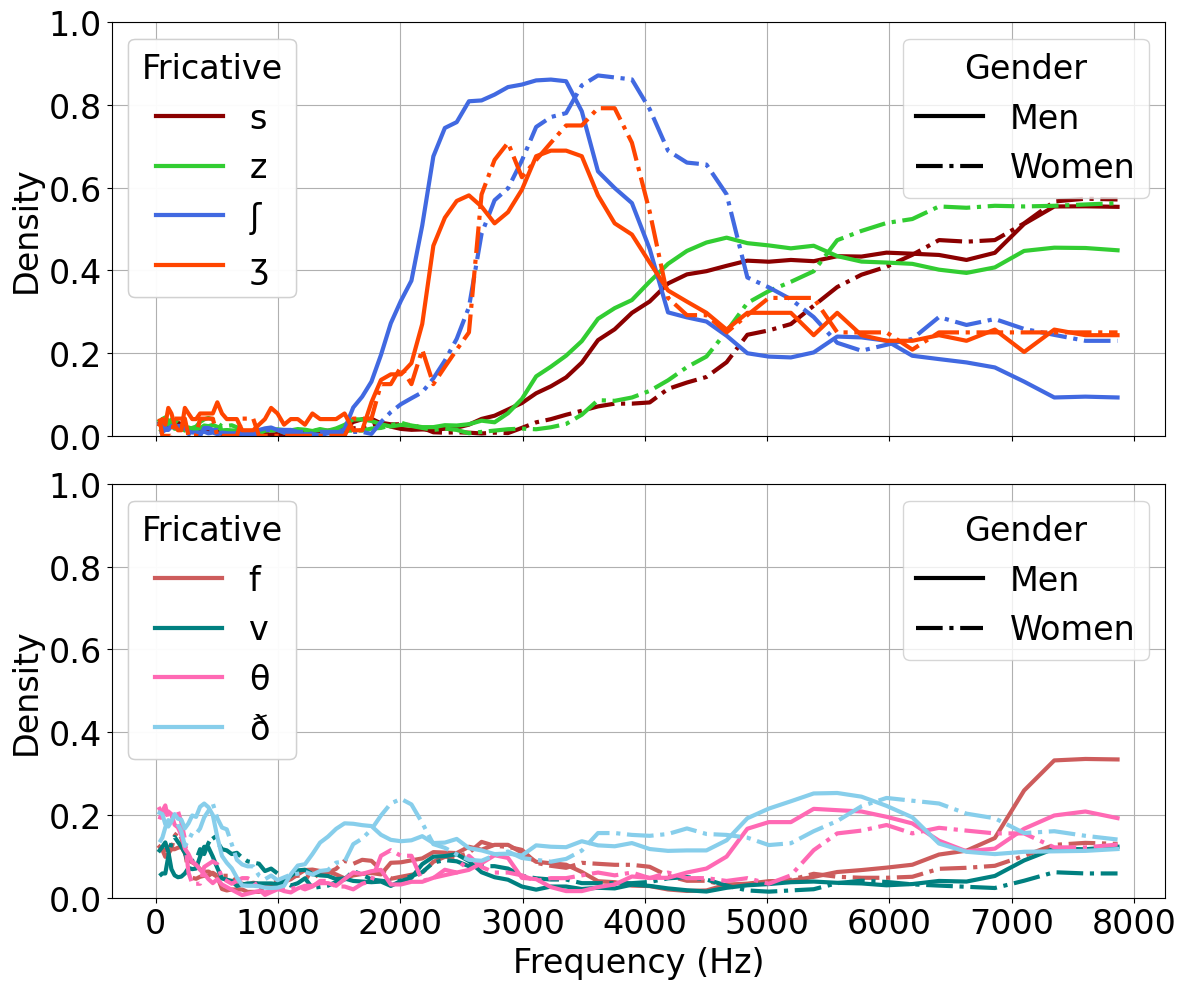

In [18]:
font_size=24

sibilants_colors = ['darkred', 'limegreen', 'royalblue', 'orangered']
nonsibilants_colors = ['indianred', 'teal', 'hotpink', 'skyblue']

# Create a figure with two subplots (2 rows, 1 column)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# First Plot: SIBILANTS
plot_lines_gender = []
plot_lines_phoneme = []
colors = itertools.cycle(sibilants_colors)

for idx, p in enumerate(SIBILANTS):
    # Calculate averages for M and F
    exp_frames_M = torch.stack(count_dict_M[p]["exp_frame"], dim=0)
    exp_avg_M = torch.mean(exp_frames_M, dim=0)

    exp_frames_F = torch.stack(count_dict_F[p]["exp_frame"], dim=0)
    exp_avg_F = torch.mean(exp_frames_F, dim=0)

    # Get the next color from the cycle
    color = next(colors)

    # Plot data for M and F
    l1, = axes[0].plot(f, exp_avg_M, "-", label=f"{p} (M)", color=color, lw=3)
    l2, = axes[0].plot(f, exp_avg_F, "-.", label=f"{p} (F)", color=color, lw=3)

    # Append lines for legends
    plot_lines_gender.append([l1, l2])
    plot_lines_phoneme.append(l1)

# Add legends and labels to the first plot
legend_handle_m = Line2D([0], [0], color='black', lw=3, linestyle='-')
legend_handle_f = Line2D([0], [0], color='black', lw=3, linestyle='-.')
legend1 = axes[0].legend(
    [legend_handle_m, legend_handle_f],
    ["Men", "Women"], loc=1,
    fontsize=font_size,
    title="Gender",
    title_fontsize=font_size)
axes[0].add_artist(legend1)
phoneme_labels = [SIBILANTS_IPA[p] for p in SIBILANTS]
legend2 = axes[0].legend(
    plot_lines_phoneme,
    phoneme_labels,
    loc=2,
    fontsize=font_size,
    title="Fricative",
    title_fontsize=font_size)
axes[0].add_artist(legend2)
axes[0].set_ylabel("Density", fontsize=font_size)
axes[0].set_ylim(0, 1)  # Set y-range for the first plot
axes[0].grid()

# Remove x-axis label from the first subplot
axes[0].tick_params(axis='y', labelsize=font_size)

# Second Plot: NONSIBILANTS
plot_lines_gender = []
plot_lines_phoneme = []
colors = itertools.cycle(nonsibilants_colors)

for idx, p in enumerate(NONSIBILANTS):
    # Calculate averages for M and F
    exp_frames_M = torch.stack(count_dict_M[p]["exp_frame"], dim=0)
    exp_avg_M = torch.mean(exp_frames_M, dim=0)

    exp_frames_F = torch.stack(count_dict_F[p]["exp_frame"], dim=0)
    exp_avg_F = torch.mean(exp_frames_F, dim=0)

    # Get the next color from the cycle
    color = next(colors)

    # Plot data for M and F
    l1, = axes[1].plot(f, exp_avg_M, "-", label=f"{p} (M)", color=color, lw=3)
    l2, = axes[1].plot(f, exp_avg_F, "-.", label=f"{p} (F)", color=color, lw=3)

    # Append lines for legends
    plot_lines_gender.append([l1, l2])
    plot_lines_phoneme.append(l1)

# Add legends and labels to the second plot
legend_handle_m = Line2D([0], [0], color='black', lw=3, linestyle='-')
legend_handle_f = Line2D([0], [0], color='black', lw=3, linestyle='-.')
legend1 = axes[1].legend(
    [legend_handle_m, legend_handle_f],
    ["Men", "Women"],
    loc=1,
    fontsize=font_size,
    title="Gender",
    title_fontsize=font_size)
axes[1].add_artist(legend1)

phoneme_labels = [NONSIBILANTS_IPA[p] for p in NONSIBILANTS]
legend2 = axes[1].legend(
    plot_lines_phoneme,
    phoneme_labels,
    loc=2,
    fontsize=font_size,
    title="Fricative",
    title_fontsize=font_size)
axes[1].add_artist(legend2)
axes[1].set_xlabel("Frequency (Hz)", fontsize=font_size)
axes[1].set_ylabel("Density", fontsize=font_size)
axes[1].set_ylim(0, 1)  # Set y-range for the second plot
axes[1].grid()

# Set font size for x- and y-ticks in the second subplot
axes[1].tick_params(axis='x', labelsize=font_size)
axes[1].tick_params(axis='y', labelsize=font_size)

plt.tight_layout()
plt.show()

#### Plosives

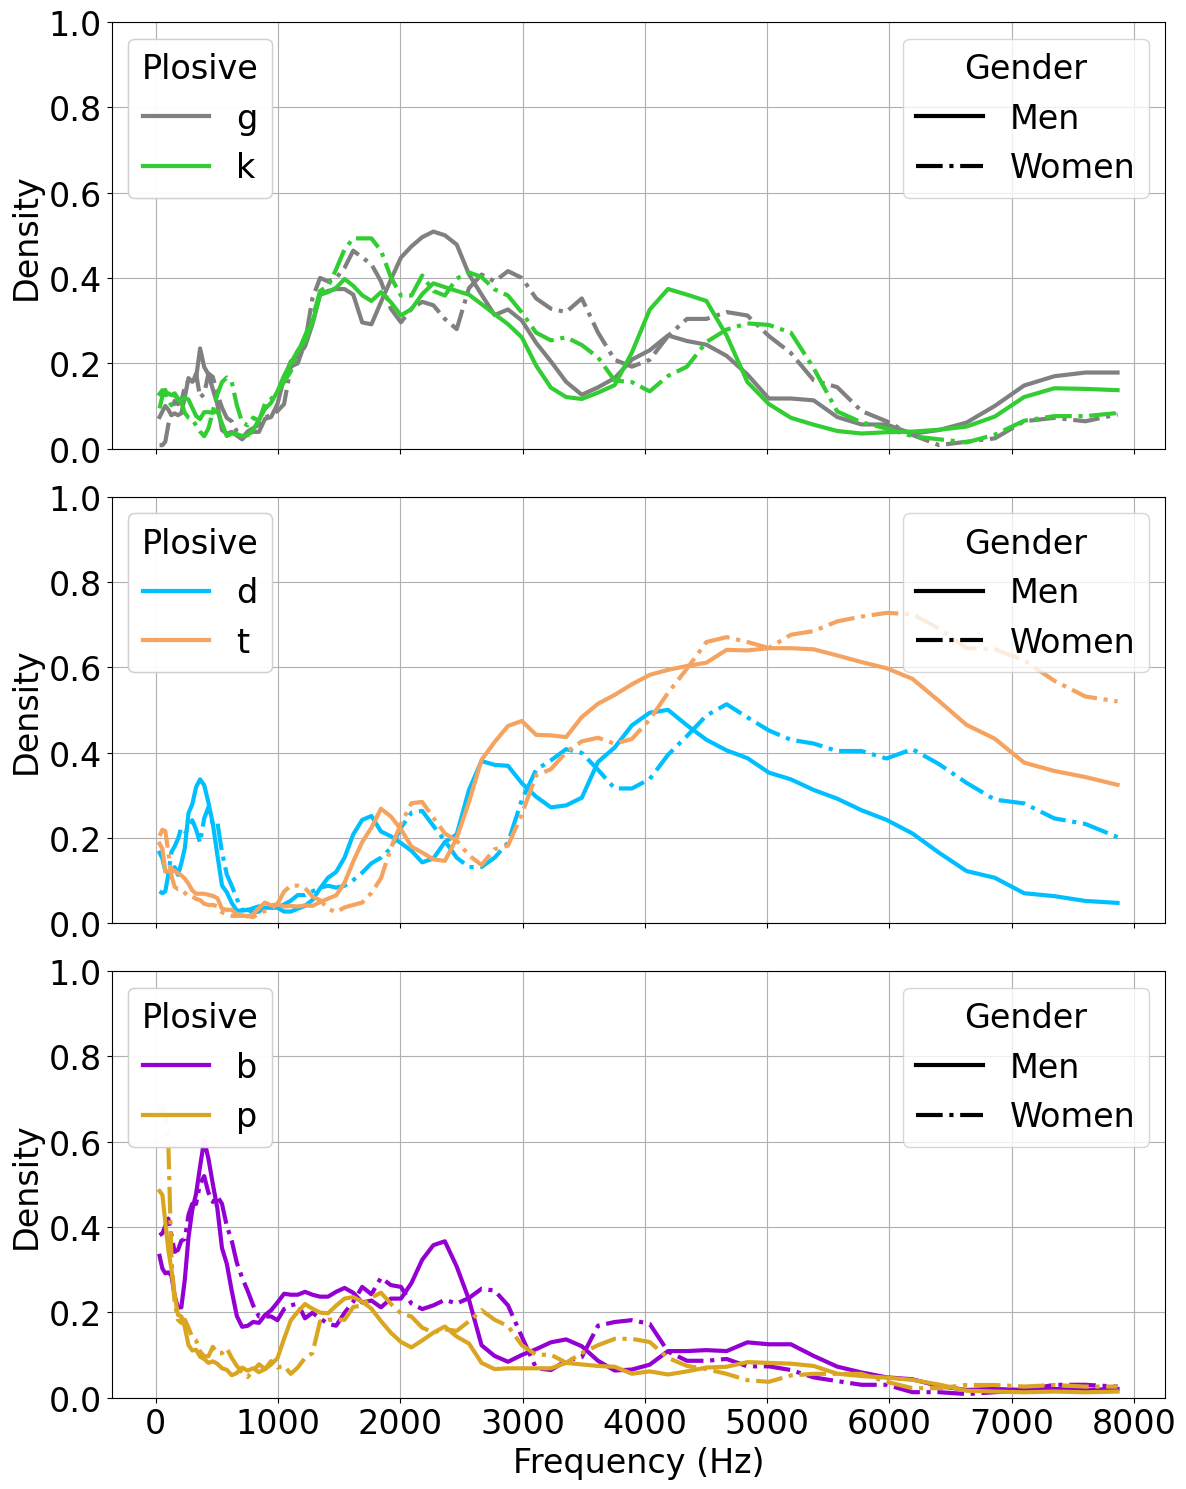

In [19]:
font_size = 24

categories = {
    "VELARS": ["g", "k"],
    "ALVEOLARS": ["d", "t"],
    "BILABIALS": ["b", "p"]}

custom_colors = ['grey', 'limegreen', 'deepskyblue', 'sandybrown', 'darkviolet', 'goldenrod']
colors = itertools.cycle(custom_colors)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15), sharex=True)

for ax, (category, phonemes) in zip(axes, categories.items()):
    # Create lists to store plot lines for legends
    plot_lines_gender = []
    plot_lines_phoneme = []

    for p in phonemes:
        exp_frames_M = torch.stack(count_dict_M[p]["exp_frame"], dim=0)
        exp_avg_M = torch.mean(exp_frames_M, dim=0)

        exp_frames_F = torch.stack(count_dict_F[p]["exp_frame"], dim=0)
        exp_avg_F = torch.mean(exp_frames_F, dim=0)

        color = next(colors)

        # Plot M data (solid line) with the same color
        l1, = ax.plot(f, exp_avg_M, "-", label=f"{p} (M)", color=color, lw=3)

        # Plot F data (dashed line) with the same color
        l2, = ax.plot(f, exp_avg_F, "-.", label=f"{p} (F)", color=color, lw=3)

        # Add both lines to the gender legend
        plot_lines_gender.append([l1, l2])

        # Add the line for phoneme legend (color-based) – one line for each phoneme
        plot_lines_phoneme.append(l1)

    # Add legends to the subplot
    # Gender Legend
    legend_handle_m = Line2D([0], [0], color='black', lw=3, linestyle='-')   # Solid line for Men
    legend_handle_f = Line2D([0], [0], color='black', lw=3, linestyle='-.')  # Dash-dot line for Women
    legend1 = ax.legend([legend_handle_m, legend_handle_f], ["Men", "Women"], loc=1, fontsize=font_size, title="Gender", title_fontsize=font_size)
    ax.add_artist(legend1)

    # Phoneme Legend
    phoneme_labels = [p for p in phonemes]
    legend2 = ax.legend(plot_lines_phoneme, phoneme_labels, loc=2, fontsize=font_size, title="Plosive", title_fontsize=font_size)
    ax.add_artist(legend2)

    ax.set_ylabel("Density", fontsize=font_size)
    ax.grid()

    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

    ax.set_ylim(0, 1)

axes[-1].set_xlabel("Frequency (Hz)", fontsize=font_size)

plt.tight_layout()
plt.show()

#### Vowels

In [26]:
vowel_formants_M = {}

for p in VOWELS:
    all_formants = count_dict_M[p]["cue"]
    formants = {"f1": [], "f2": [], "f3": [], "f4": []}

    for row in all_formants:
        for f in row.keys():
            if not np.isnan(row[f]):
                formants[f].append(row[f])

    vowel_formants_M[p] = formants


vowel_formants_F = {}

for p in VOWELS:
    all_formants = count_dict_F[p]["cue"]
    formants = {"f1": [], "f2": [], "f3": [], "f4": []}

    for row in all_formants:
        for f in row.keys():
            if not np.isnan(row[f]):
              formants[f].append(row[f])

    vowel_formants_F[p] = formants

In [27]:
print(f"{'Vowel':<6} {'Formant':<7} {'Avg (M)':<10} {'Std (M)':<10} {'Avg (F)':<10} {'Std (F)':<10}")
print("-" * 55)

for i, p in enumerate(VOWELS):
    # Calculate averages and standard deviations for M and F
    f1_avg_M = torch.mean(torch.tensor(vowel_formants_M[p]["f1"]))
    f1_std_M = torch.std(torch.tensor(vowel_formants_M[p]["f1"]))
    f2_avg_M = torch.mean(torch.tensor(vowel_formants_M[p]["f2"]))
    f2_std_M = torch.std(torch.tensor(vowel_formants_M[p]["f2"]))
    f3_avg_M = torch.mean(torch.tensor(vowel_formants_M[p]["f3"]))
    f3_std_M = torch.std(torch.tensor(vowel_formants_M[p]["f3"]))
    f4_avg_M = torch.mean(torch.tensor(vowel_formants_M[p]["f4"]))
    f4_std_M = torch.std(torch.tensor(vowel_formants_M[p]["f4"]))

    f1_avg_F = torch.mean(torch.tensor(vowel_formants_F[p]["f1"]))
    f1_std_F = torch.std(torch.tensor(vowel_formants_F[p]["f1"]))
    f2_avg_F = torch.mean(torch.tensor(vowel_formants_F[p]["f2"]))
    f2_std_F = torch.std(torch.tensor(vowel_formants_F[p]["f2"]))
    f3_avg_F = torch.mean(torch.tensor(vowel_formants_F[p]["f3"]))
    f3_std_F = torch.std(torch.tensor(vowel_formants_F[p]["f3"]))
    f4_avg_F = torch.mean(torch.tensor(vowel_formants_F[p]["f4"]))
    f4_std_F = torch.std(torch.tensor(vowel_formants_F[p]["f4"]))

    # Print results for each formant
    print(f"{p:<6} {'F1':<7} {f1_avg_M:<10.2f} {f1_std_M:<10.2f} {f1_avg_F:<10.2f} {f1_std_F:<10.2f}")
    print(f"{'':<6} {'F2':<7} {f2_avg_M:<10.2f} {f2_std_M:<10.2f} {f2_avg_F:<10.2f} {f2_std_F:<10.2f}")
    print(f"{'':<6} {'F3':<7} {f3_avg_M:<10.2f} {f3_std_M:<10.2f} {f3_avg_F:<10.2f} {f3_std_F:<10.2f}")
    print(f"{'':<6} {'F4':<7} {f4_avg_M:<10.2f} {f4_std_M:<10.2f} {f4_avg_F:<10.2f} {f4_std_F:<10.2f}")
    print("-" * 55)


Vowel  Formant Avg (M)    Std (M)    Avg (F)    Std (F)   
-------------------------------------------------------
aa     F1      695.25     61.66      827.65     86.96     
       F2      1191.50    121.76     1368.28    154.39    
       F3      2321.00    299.10     2631.67    365.73    
       F4      3361.96    279.28     3803.22    327.57    
-------------------------------------------------------
ae     F1      659.10     62.59      792.82     95.65     
       F2      1653.20    181.86     1960.01    281.73    
       F3      2437.71    196.34     2836.15    298.43    
       F4      3428.37    308.74     3988.09    421.25    
-------------------------------------------------------
ah     F1      620.42     63.68      720.41     88.19     
       F2      1309.76    149.09     1571.52    195.12    
       F3      2437.06    233.24     2842.30    310.09    
       F4      3385.94    251.81     3954.41    353.28    
-------------------------------------------------------
eh     F1

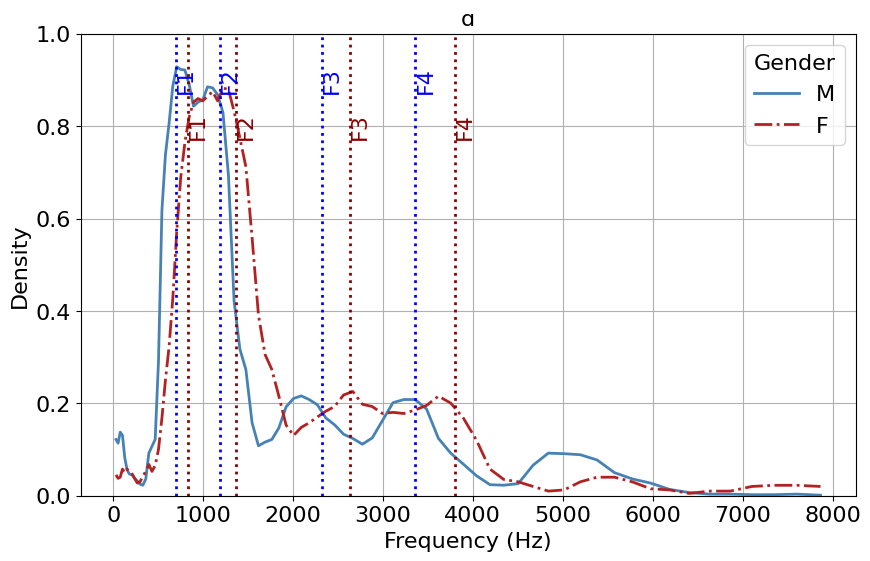

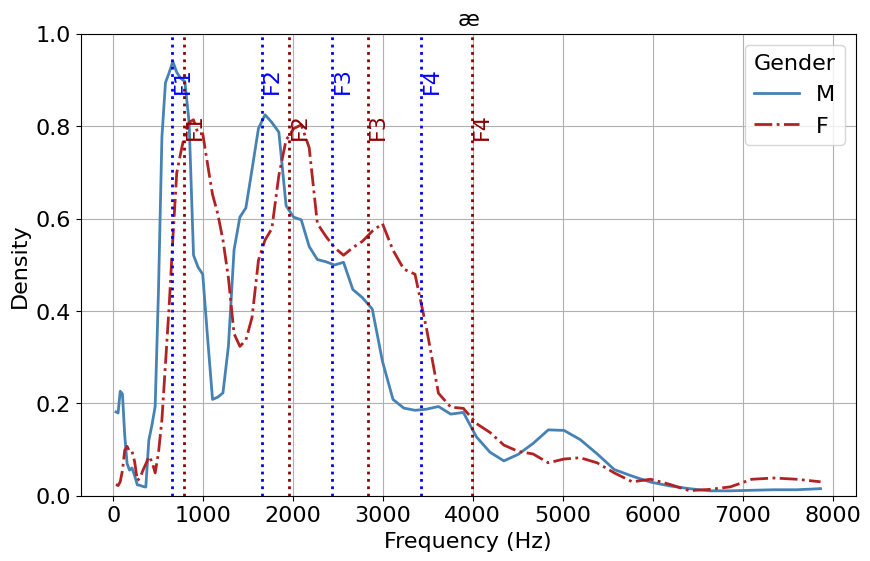

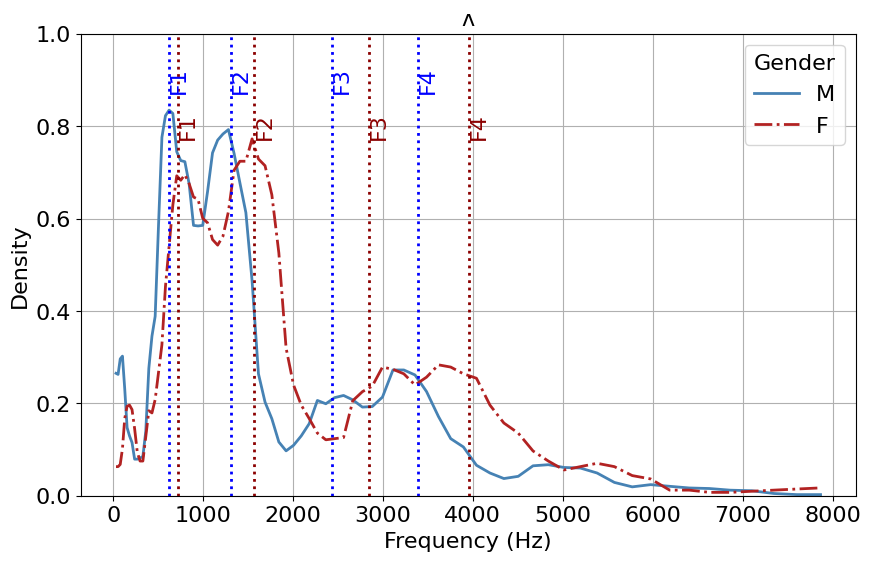

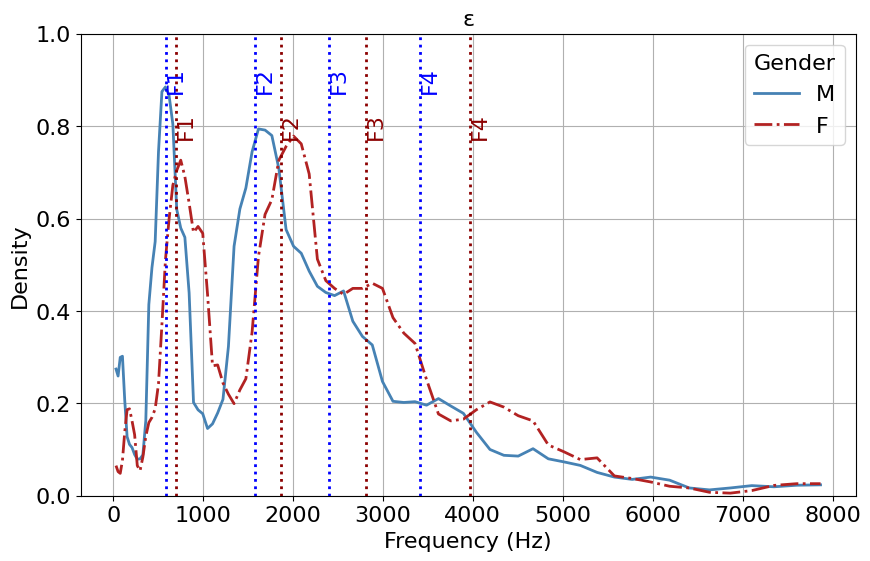

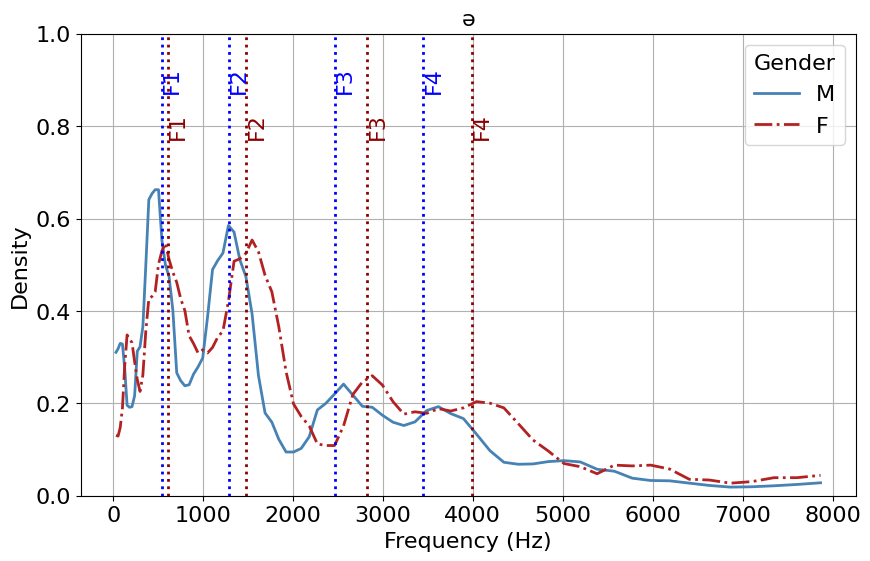

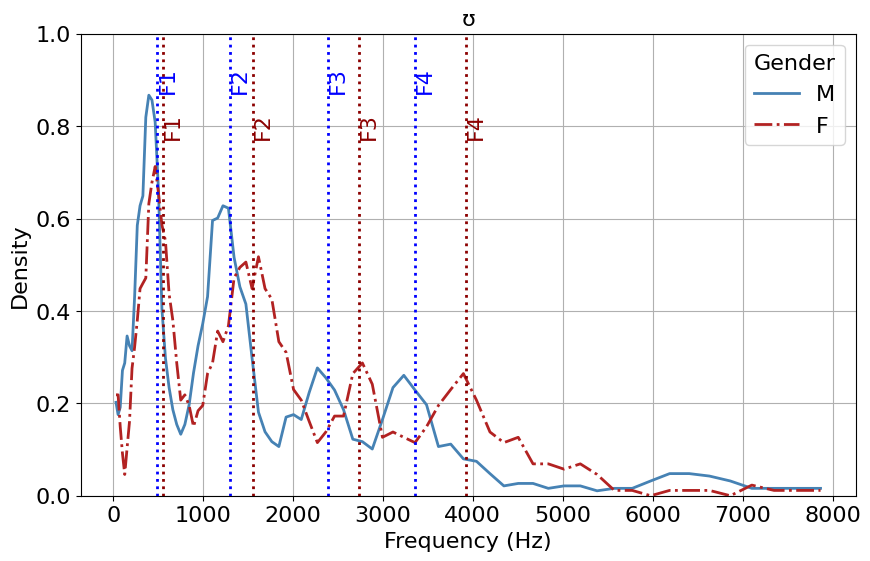

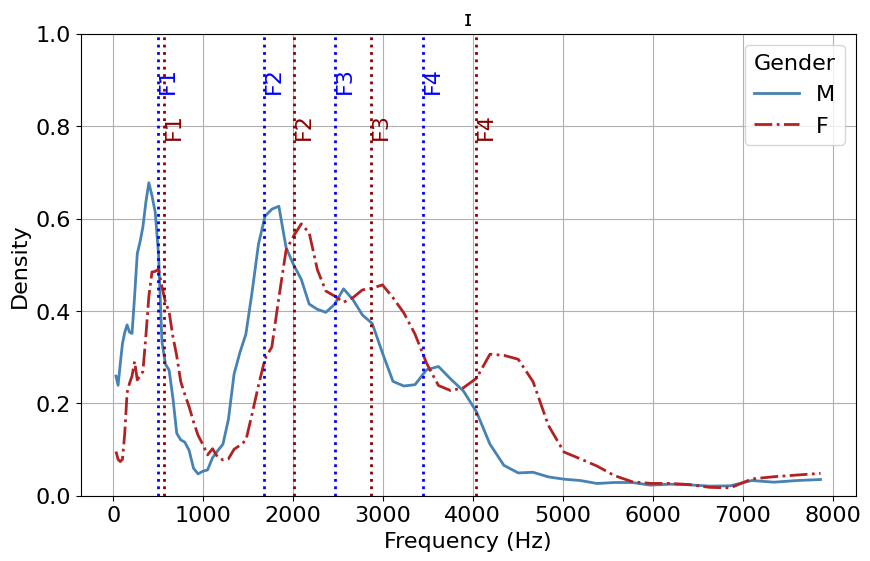

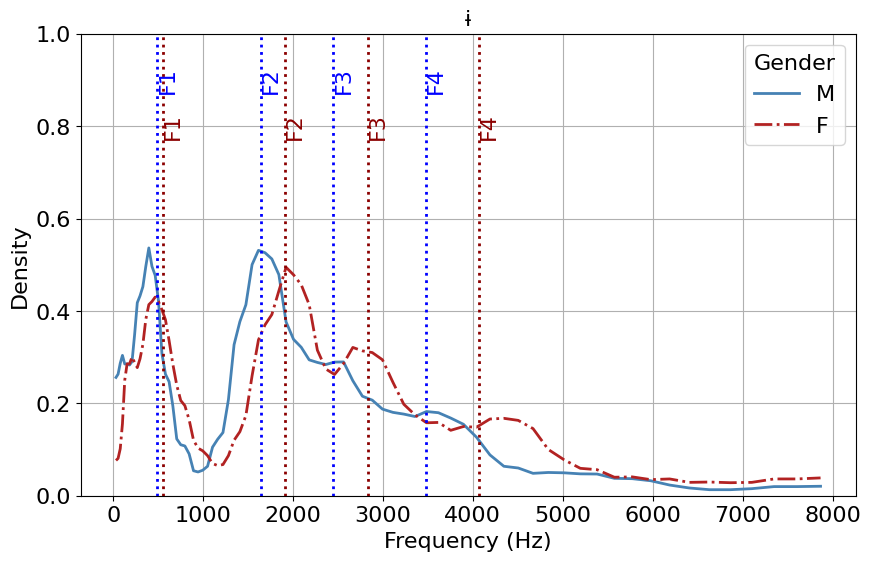

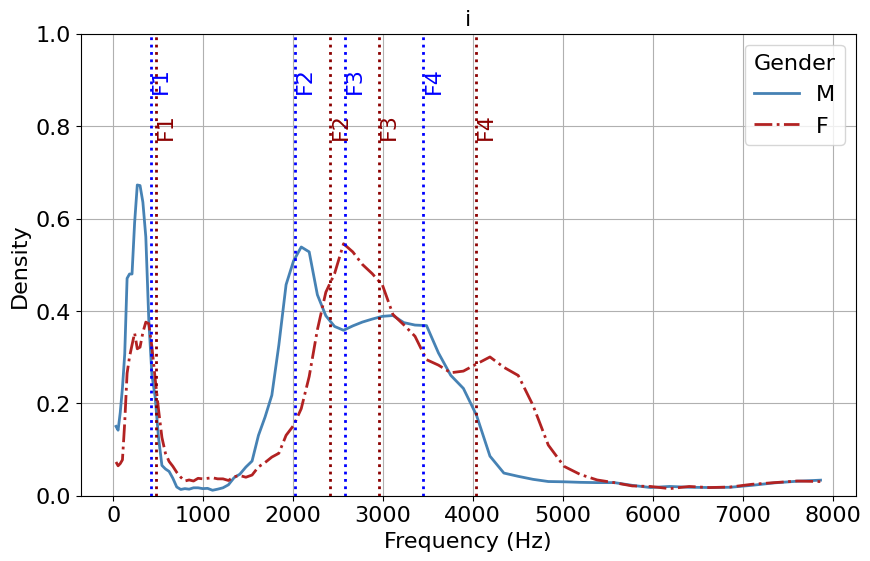

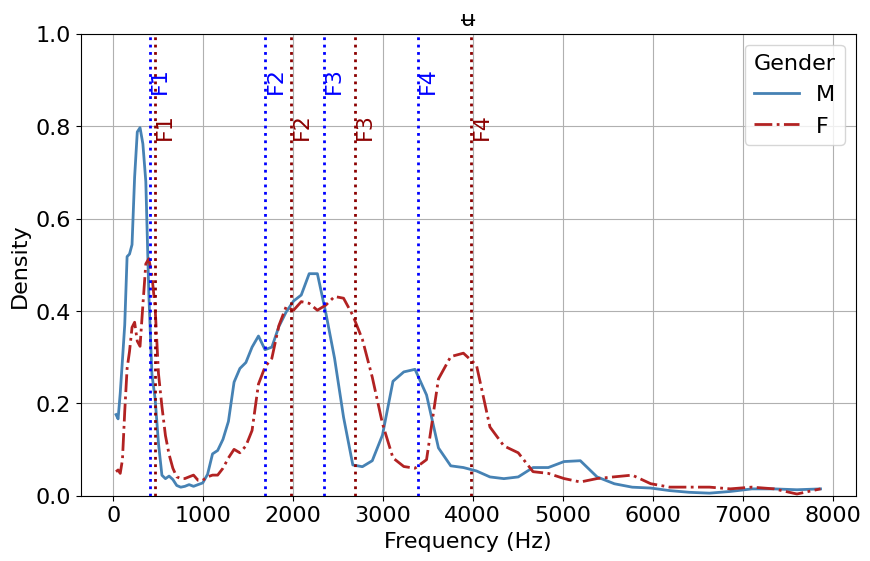

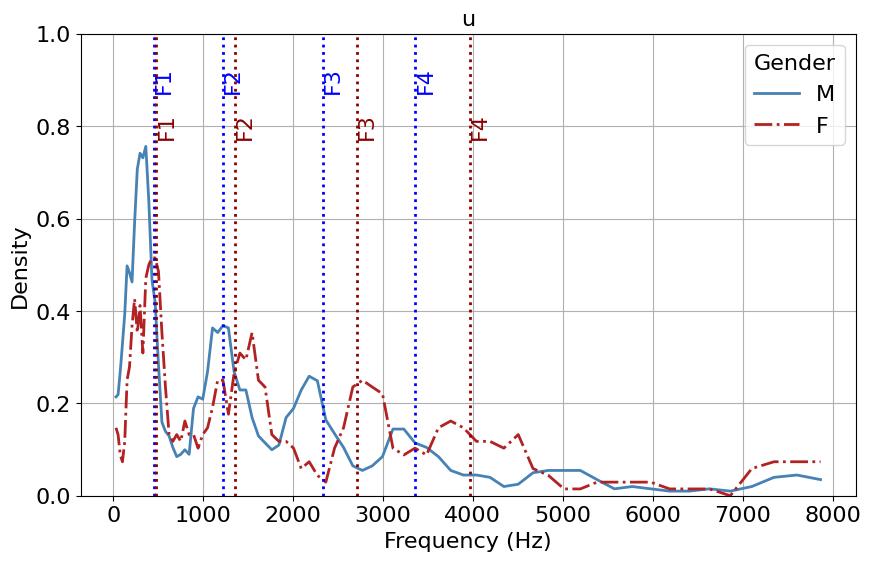

In [28]:
font_size = 16

plt.rcParams.update({
    "font.size": font_size,
    "axes.titlesize": font_size,
    "axes.labelsize": font_size,
    "xtick.labelsize": font_size,
    "ytick.labelsize": font_size,
    "legend.fontsize": font_size,
    "legend.title_fontsize": font_size})

for i, p in enumerate(VOWELS):
    # Calculate averages for M and F
    exp_frames_M = torch.stack(count_dict_M[p]["exp_frame"], dim=0)
    exp_avg_M = torch.mean(exp_frames_M, dim=0)
    f1_M, f2_M, f3_M, f4_M = [
        torch.mean(torch.tensor(vowel_formants_M[p][f"f{i}"])) for i in range(1, 5)]

    exp_frames_F = torch.stack(count_dict_F[p]["exp_frame"], dim=0)
    exp_avg_F = torch.mean(exp_frames_F, dim=0)
    f1_F, f2_F, f3_F, f4_F = [
        torch.mean(torch.tensor(vowel_formants_F[p][f"f{i}"])) for i in range(1, 5)]

    plt.figure(figsize=(10, 6))  # Adjust figure size if needed
    plt.plot(hz_centers, exp_avg_M.numpy(), "-", color="steelblue", label="M", lw=2)
    plt.plot(hz_centers, exp_avg_F.numpy(), "-.", color="firebrick", label="F", lw=2)

    # Add vertical lines and labels for M
    for freq, label in zip([f1_M, f2_M, f3_M, f4_M], ["F1", "F2", "F3", "F4"]):
        plt.axvline(freq, color="blue", linestyle="dotted", lw=2)
        plt.text(freq, 0.9, label, color="blue", rotation=90, verticalalignment='center')

    # Add vertical lines and labels for F
    for freq, label in zip([f1_F, f2_F, f3_F, f4_F], ["F1", "F2", "F3", "F4"]):
        plt.axvline(freq, color="darkred", linestyle="dotted", lw=2)
        plt.text(freq, 0.8, label, color="darkred", rotation=90, verticalalignment='center')

    plt.title(VOWEL_MAPPING[p])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Density")
    plt.ylim(0, 1)
    plt.legend(title="Gender")
    plt.grid()

    plt.show()